In [61]:
import pandas as pd
import numpy as np
import re
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [60]:
pip install seaborn

In [62]:
data = pd.read_csv('properatti.csv')
title = data['title']
description = data['description']

In [63]:
data['price_aprox_usd'] = data['price_aprox_usd'].round()
data['price_aprox_usd'] = data['price_aprox_usd'].astype('int', errors='ignore')
pd.options.display.max_columns = None

In [64]:
#buscamos mediante un patron y el uso de expresiones regulares los precios en USD que estan en la columna de title
patron = '^U\$D \d*.\d*.\d*'
title_regex = re.compile(patron)
resultado = title.apply(lambda x:  x if x is np.NaN else title_regex.search(x))

#buscamos mediante un patron y el uso de expresiones regulares los precios en USD que estan en la columna de description
patron_d = 'U\$S \d*.\d*.\d*'
description_regex = re.compile(patron_d)
resultado_d = description.apply(lambda x:  x if x is np.NaN else description_regex.search(x))

#buscamos mediante un patron y el uso de expresiones regulares los m2 que estan en la columna de title
patron_m = '(?:\d+ (?:m2|M2)|\d+(?:m2|M2))'
title_regex_m = re.compile(patron_m)
resultado_m = title.apply(lambda x:  x if x is np.NaN else title_regex_m.search(x))

In [65]:
# las coincidencias con el patron se volcaron a nueva columna Titleclean
mask_notnull = resultado.notnull()
data.loc[mask_notnull, "TitleClean"] = resultado[mask_notnull].apply(lambda x: x.group(0))
dolar= data.loc[mask_notnull, ["TitleClean"]]

# las coincidencias con el patron se volcaron a nueva columna Descriptionclean
mask_notnull_d = resultado_d.notnull()
data.loc[mask_notnull_d, "DescriptionClean"] = resultado_d[mask_notnull_d].apply(lambda x: x.group(0))
dolar_d= data.loc[mask_notnull_d, ["DescriptionClean"]]

# las coincidencias con el patron se volcaron a nueva columna Title_m2
mask_notnull_m = resultado_m.notnull()
data.loc[mask_notnull_m, "Title_m2"] = resultado_m[mask_notnull_m].apply(lambda x: x.group(0))
dolar_m= data.loc[mask_notnull_m, ["Title_m2"]]

In [66]:
# Cambiamos el type a string, ya que las funciones que continuan emitian error si no era tipo string.
title_clean = data['TitleClean']
title_clean2 = title_clean.apply(str)
description_clean = data['DescriptionClean']
description_clean2 = description_clean.apply(str)
title_clean_m = data['Title_m2']
title_clean_m2 = title_clean_m.apply(str)

In [67]:
# mediante el uso de un nuevo patron quitamos el signo U$D para quedarnos solo con el precio (sin la moneda)
patron_usd = '\d+\d+\d+'
title_clean2_regex = re.compile(patron_usd)
resultado2 = title_clean2.apply(lambda x:  x if x is np.NaN else title_clean2_regex.search(x))

# mediante el uso de un nuevo patron quitamos el signo U$S para quedarnos solo con el precio (sin la moneda)
patron_usd_d = '\d+\d+\d+'
description_clean2_regex = re.compile(patron_usd_d)
resultado2_d = description_clean2.apply(lambda x:  x if x is np.NaN else description_clean2_regex.search(x))

# mediante el uso de un nuevo patron quitamos el signo m2 para quedarnos solo con la superficie
patron_m2 = '^\d+'
title_clean_m2_regex = re.compile(patron_m2)
resultado2_m = title_clean_m2.apply(lambda x:  x if x is np.NaN else title_clean_m2_regex.search(x))

In [68]:
# lo volcamos a una nueva columna SinUSD
mask2_notnull = resultado2.notnull()
data.loc[mask2_notnull, "SinUSD"] = resultado2[mask2_notnull].apply(lambda x: x.group(0))
dolar2= data.loc[mask2_notnull, ["SinUSD"]]

In [69]:
# Eliminamos los puntos y lo convertimos en float
data["SinUSD"] = data["SinUSD"].replace(to_replace =".", value ="").astype(int, errors='ignore')
#data[data["SinUSD"].notnull()]

In [70]:
# lo volcamos a una nueva columna SinUSS
mask2_notnull_d = resultado2_d.notnull()
data.loc[mask2_notnull_d, "SinUSS"] = resultado2_d[mask2_notnull_d].apply(lambda x: x.group(0))
dolar2_d= data.loc[mask2_notnull_d, ["SinUSS"]]

# lo volcamos a una nueva columna Sin_m2
mask2_notnull_m = resultado2_m.notnull()
data.loc[mask2_notnull_m, "Sin_m2"] = resultado2_m[mask2_notnull_m].apply(lambda x: x.group(0))
dolar2_m= data.loc[mask2_notnull_m, ["Sin_m2"]]

In [71]:
#completamos los campos vacios de precios en usd por lo nuevos ,sacados de title, reflejados en SinUSD
data.price_aprox_usd.fillna(data.SinUSD, inplace=True)

#completamos los campos vacios de precios en usd por lo nuevos ,sacados de description, reflejados en SinUSS
data.price_aprox_usd.fillna(data.SinUSS, inplace=True)

#completamos los campos vacios de metros en m2 por lo nuevos ,sacados de title, reflejados en Sin_m2
data.surface_total_in_m2.fillna(data.Sin_m2, inplace=True)

In [72]:
#creamos un sub data solo con los valores de Capital Federal, para reducir el dataset y enfocar el análisis en una de las zonas con mayor cantidad de registros.
caba = data.state_name == "Capital Federal"
data_caba = data [caba]

In [73]:
# Dropeamos las filas que tienen el precio nulo dado que no era una cantidad significativa de casos y no se podía conseguir con información de otras columnas del dataset
data_caba.dropna(subset=['price_aprox_usd'], inplace=True)

# Quitamos el warning resultante con la siguiente función:
pd.options.mode.chained_assignment = None

In [74]:
#Convertimos a flotante los datos de la columna superficie total en m2
data_caba['surface_total_in_m2'] = data_caba['surface_total_in_m2'].apply(lambda x: float(x))

In [75]:
#Convertimos a flotante los datos de la columna precio en dolares
data_caba['price_aprox_usd'] = data_caba['price_aprox_usd'].apply(lambda x: float(x))

In [76]:
# Analizamos los outliers en la columna precio aprox en dolar
data_caba['id'] = np.arange(len(data_caba))

In [ ]:
# Graficamos los precios por barrio

app = Dash(__name__)
data= data_caba

app.layout = html.Div([
    html.H4('Interactive scatter plot with Iris dataset'),
    dcc.Graph(id="scatter-plot"),
    html.P("Filter by petal width:"),
    dcc.RangeSlider(
        id='range-slider',
        min=0, max=10000000, step=1000,
        marks={0: '0', 10000000: '10.000.000'},
        value=[10000,450000 ]
    ),
])


@app.callback(
    Output("scatter-plot", "figure"), 
    Input("range-slider", "value"))
def update_bar_chart(slider_range):
    df = data # replace with your own data source
    low, high = slider_range
    mask = (data['price_aprox_usd'] > low) & (data['price_aprox_usd'] < high)
    fig = px.scatter(
        data[mask], x="place_name", y="price_aprox_usd", 
        color="price_aprox_usd", size='price_aprox_usd', 
        hover_data=['id'])
    return fig


app.run_server(debug=True, use_reloader=False)

In [77]:
# En base al grafico se identifican los outliers y se quitan de la base
outlayers = (data_caba['price_aprox_usd'] > 20000000) | (data_caba['price_aprox_usd'] < 15000)
outlayers_index = data_caba[outlayers].index
data_caba = data_caba.drop(outlayers_index)

In [78]:
#Agrupamos por barrio
dataset_groupby_barrio = data_caba.groupby('place_name')

In [79]:
#Completamos los valores nulos de price_usd_per_m2 (superficie total) con el promedio segun su barrio, usando transform y lambda.
price_m2_usd_filled = dataset_groupby_barrio['price_usd_per_m2'].transform(lambda grp: grp.fillna(grp.mean()))

In [80]:
#Completamos los valores nulos de price_per_m2 (superficie cubierta) con el promedio segun su barrio, usando transform y lambda.
price_m2_filled = dataset_groupby_barrio['price_per_m2'].transform(lambda grp: grp.fillna(grp.mean()))

In [81]:
#Agregamos la columna de m2_usd_filled al dataset
data_caba.loc[:, ['price_usd_m2_filled']] = price_m2_usd_filled
price_usd_fill = data_caba['price_usd_m2_filled']

In [82]:
#Agregamos la columna de m2_usd_filled al dataset
data_caba.loc[:, ['price_m2_filled']] = price_m2_filled
price_m2_fill = data_caba['price_m2_filled']

In [83]:
# Para controlar imprimimos la cantidad de nulos en precio por m2
print(data_caba.price_usd_m2_filled	.isnull().sum())
print(data_caba.price_m2_filled.isnull().sum())

0
0


In [84]:
#Nos quedamos solo con los barrios y sus precios_usd_m2
data_por_barrio = data_caba.loc[:,['place_name', 'price_usd_m2_filled',]]


In [85]:
#Vamos a graficar los 10 barrios con mayor precio por m2. Primero agrupamos
precio_m2_usd_por_barrio = data_por_barrio.groupby('place_name')['price_usd_m2_filled'].mean().round(2)

In [86]:
#Lo convertimos a data frame y filtramos por top 10.
precio_m2_usd_por_barrio.to_frame()
df = pd.DataFrame([precio_m2_usd_por_barrio]).T
df2 = df.nlargest(10, 'price_usd_m2_filled')
df2

,price_usd_m2_filled
place_name,
Boedo,10697.51
San Cristobal,9952.39
Puerto Madero,6029.69
Palermo Chico,4797.33
Las Cañitas,3476.18
Recoleta,3392.86
Palermo,3391.18
Nuñez,3246.57
Palermo Soho,3216.46


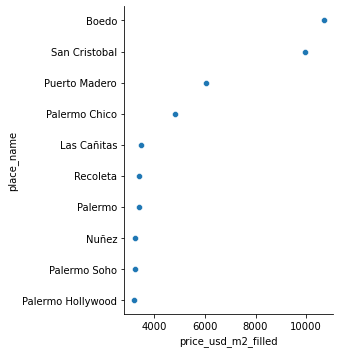

In [87]:
#Graficamos
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.relplot(x = 'price_usd_m2_filled', y = 'place_name', data = df2, palette = 'ch:r=-0.5, l= 0.95')




plt.show()

In [92]:
# Completamos los mts2 vacios con la informacion de price_usd_per_m2 (superficie total) / price_aprox_usd a completrar en la columna surface_total_in_m2 

data_caba["mts2_completar"] = data_caba.price_aprox_usd / data_caba.price_usd_m2_filled
data_caba.surface_total_in_m2.fillna(data_caba.mts2_completar, inplace=True)


In [94]:
# Creamos rangos de m2 con un pd.cut para falicitar el análisis de los tipos de propiedades
bins = [0,50,100,300000]
cuantil = pd.cut(data_caba['surface_total_in_m2'], bins, right=False)
cuantil.value_counts()

[50, 100)        10432
[0, 50)          10359
[100, 300000)     8193
Name: surface_total_in_m2, dtype: int64

In [95]:
pd.options.display.max_rows = None
grp_barrio = data_caba.groupby(['property_type',cuantil])[['price_usd_m2_filled','price_aprox_usd']].mean().round(2)
grp_barrio

price_usd_m2_filled  price_aprox_usd
property_type surface_total_in_m2                                      
PH            [0, 50)                          3469.92        101316.32
              [50, 100)                        2012.86        141754.90
              [100, 300000)                    1557.58        252918.96
apartment     [0, 50)                          3856.21        136986.27
              [50, 100)                        2639.94        180648.64
              [100, 300000)                    3179.63        574940.96
house         [0, 50)                          8330.78        282143.82
              [50, 100)                        2450.42        187791.59
              [100, 300000)                    1603.85        527297.40
store         [0, 50)                          3578.86        103491.40
              [50, 100)                        3203.81        226960.34
              [100, 300000)                    2494.47        786583.74

In [96]:
# Mostramos el dataset conformado con un ejemplo de 10 filas
data_caba.head(10)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,TitleClean,DescriptionClean,Title_m2,SinUSD,SinUSS,Sin_m2,id,price_usd_m2_filled,price_m2_filled,mts2_completar
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,1093959.00,62000.0,55.00000,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,NaN,NaN,NaN,NaN,NaN,NaN,0,1127.272727,1550.000000,55.00000
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.00,72000.0,55.00000,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,NaN,NaN,NaN,NaN,NaN,NaN,1,1309.090909,1309.090909,55.00000
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,95000.0,USD,1676227.50,95000.0,52.66343,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...,NaN,NaN,NaN,NaN,NaN,NaN,2,1803.908335,2278.839694,52.66343
7,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,138000.0,USD,2434941.00,138000.0,45.00000,40.0,3066.666667,3450.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bot_venta_depart...,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,https://thumbs4.properati.com/1/IHxARynlr8sPEW...,NaN,NaN,NaN,NaN,NaN,NaN,3,3066.666667,3450.000000,45.00000
8,8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,195000.0,USD,3440677.50,195000.0,65.00000,60.0,3000.000000,3250.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bou_venta_depart...,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",https://thumbs4.properati.com/2/J3zOjgaFHrkvnv...,NaN,NaN,NaN,NaN,NaN,NaN,4,3000.000000,3250.000000,65.00000
13,13,sell,apartment,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,3430234.0,NaN,NaN,NaN,111700.0,USD,1970890.65,111700.0,50.00000,30.0,2234.000000,3723.333333,NaN,1.0,NaN,http://www.properati.com.ar/15bp9_venta_depart...,Torre I Mondrian. 3 ambientes con terraza y d...,Vitraux Palermo,https://thumbs4.properati.com/2/ZTUjkRzTz6YvcU...,NaN,NaN,NaN,NaN,NaN,NaN,5,2234.000000,3723.333333,50.00000
14,14,sell,apartment,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,3430234.0,NaN,NaN,NaN,147900.0,USD,2609621.55,147900.0,42.00000,31.0,3521.428571,4770.967742,NaN,1.0,NaN,http://www.properati.com.ar/15bpa_venta_depart...,Torre II Dalí. Ambiente unico divisible.Vitrau...,Vitraux Palermo,https://thumbs4.properati.com/8/Uay2dC732CNlRw...,NaN,NaN,NaN,NaN,NaN,NaN,6,3521.428571,4770.967742,42.00000
16,16,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6523561177,-58.5016239381",-34.652356,-58.501624,239000.0,USD,4217035.50,239000.0,140.00000,98.0,1707.142857,2438.775510,NaN,4.0,NaN,http://www.properati.com.ar/15bpj_venta_ph_mat...,Ventas Mataderos al frente Duplex

In [ ]:
#Vamos a calcular la distancia de las propiedades hasta el obelisco
#En base a esto, vamos a graficarlo para ver si existe relacion entre distancia y precio

In [97]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns

In [98]:
data=pd.read_csv('properatti.csv')
data_geo=gpd.read_file('barrios/barrios_badata_wgs84.shp')
pf = pd.DataFrame(data)
barrios_geo = data_geo

In [99]:
#Definimos mascara lat para ver info
mask_lat = data_caba['lat']

In [100]:
#Completamos los valores nulos de lat con el valor segun su barrio, usando transform y lambda.
lat_filled = dataset_groupby_barrio['lat'].transform(lambda grp: grp.fillna(grp.mean()))

In [101]:
#Agregamos la columna con los valores de lat completos. 
data_caba.loc[:, ['lat_filled']] = lat_filled
lat_filled = data_caba['lat_filled']

In [102]:
#Generamos mascara de lon para ver info
mask_lon = data_caba['lon']

In [103]:
#Completamos los valores nulos de lon con el valor segun su barrio, usando transform y lambda.
lon_filled = dataset_groupby_barrio['lon'].transform(lambda grp: grp.fillna(grp.mean()))

In [104]:
#Agregamos la columna con los valores de lon completos. 
data_caba.loc[:, ['lon_filled']] = lon_filled
lon_filled = data_caba['lon_filled']

In [105]:
#Definiendo propiedades de geo
geometria = gpd.points_from_xy(data_caba.lon_filled, data_caba.lat_filled)
geo_prop = gpd.GeoDataFrame(data_caba ,geometry=geometria)

In [106]:
#Vemos que este todo OK
geo_prop.loc[:4, ['geometry', 'lat_filled', 'lon_filled','property_type','place_name']]

,geometry,lat_filled,lon_filled,property_type,place_name
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
2,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
3,POINT (-58.51642 -34.64780),-34.647797,-58.516424,PH,Liniers


In [107]:
#Ahora calculamos la distancia de cada propiedad al obelisco
from shapely.geometry import Point

punto_obelisco_p = Point(-58.381555,-34.605425)

In [108]:
type(punto_obelisco_p)

shapely.geometry.point.Point

In [109]:
#para calcular, necesitamos que sea una tupla
punto_obelisco = (-58.381555,-34.605425)

In [110]:
type(punto_obelisco)

tuple

In [111]:
#Ahora podemos agregar la nueva columna con la distancia entre el punto del obelisco y el punto de cada propiedad (en metros). La llamaremos distancia_obelisco.

import geopy.distance

for i in geo_prop.index:
    geo_prop.loc[i, 'distancia_obelisco'] = geopy.distance.geodesic(punto_obelisco, (geo_prop.loc[i,'geometry'].x, geo_prop.loc[i,'geometry'].y)).meters

In [112]:
#Verificamos la nueva columna

geo_prop.loc[:4, ['distancia_obelisco','geometry', 'lat', 'lon','property_type','place_name']]

,distancia_obelisco,geometry,lat,lon,property_type,place_name
0,14555.078219,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
2,15988.570648,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
3,15224.874751,POINT (-58.51642 -34.64780),-34.647797,-58.516424,PH,Liniers


In [113]:
#Calculamos relacion entre distancia y precio

geo_prop_group = geo_prop.groupby(['place_name']).count()


In [ ]:
#Agregamos columnas promedio precio y distancia

In [114]:
#Promedio precios por barrio
geo_prop_group['precio']  =  geo_prop.groupby(['place_name'])[['price']].mean()

In [116]:
#Promedio distancia por barrio
geo_prop_group['distancia'] =  geo_prop.groupby(['place_name'])[['distancia_obelisco']].mean()

In [52]:
geo_prop_group.head(10)

,Unnamed: 0,operation,property_type,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,TitleClean,DescriptionClean,Title_m2,SinUSD,SinUSS,Sin_m2,id,price_usd_m2_filled,price_m2_filled,lat_filled,lon_filled,geometry,distancia_obelisco,precio,distancia
place_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abasto,101,101,101,101,101,101,0,72,72,72,101,101,101,101,86,94,85,94,17,52,27,101,101,101,101,0,3,4,0,3,4,101,101,101,101,101,101,101,179511.039604,3344.005102
Agronomía,37,37,37,37,37,37,37,37,37,37,37,37,37,37,25,36,25,36,1,29,7,37,37,37,37,0,1,1,0,1,1,37,37,37,37,37,37,37,168810.135135,11597.573789
Almagro,985,985,985,985,985,985,985,900,900,900,985,985,985,985,831,951,829,951,148,665,282,985,985,985,984,0,28,41,0,25,41,985,985,985,985,985,985,985,223112.765482,4461.178131
Balvanera,631,631,631,631,631,631,631,576,576,576,631,631,631,631,480,589,473,589,140,418,189,631,631,631,630,0,26,37,0,26,37,631,631,631,631,631,631,631,171409.012678,2422.471384
Barracas,408,408,408,408,408,408,408,358,358,358,408,408,408,408,358,373,355,373,26,227,56,408,408,408,408,0,29,11,0,25,11,408,408,408,408,408,408,408,190563.514706,2138.442292
Barrio Norte,1019,1019,1019,1019,1019,1019,1019,866,866,866,1019,1019,1019,1019,891,953,889,953,98,609,345,1019,1019,1019,1012,0,31,35,0,27,35,1019,1019,1019,1019,1019,1019,1019,323846.961727,2277.200833
Belgrano,2532,2532,2532,2532,2532,2532,2532,1856,1856,1856,2532,2532,2532,2532,2127,2405,2125,2405,186,1093,705,2532,2532,2532,2514,0,82,77,0,80,77,2532,2532,2532,2532,2532,2532,2532,640384.144155,8456.329120
Boca,211,211,211,211,211,211,211,122,122,122,211,211,211,211,178,195,178,195,16,78,50,211,211,211,208,0,4,4,0,4,4,211,211,211,211,211,211,211,585779.142180,2668.129900
Boedo,858,858,858,858,858,858,858,334,334,334,858,858,858,858,804,845,800,845,19,719,37,858,858,858,858,0,30,20,0,30,20,858,858,858,858,858,858,858,412689.837995,4150.359178


In [117]:
#Y finalmente, agregar otras dos columnas con el ranking según el promedio (distancia y precio) por barrio.

# Ranking distancia por barrio
geo_prop_group["rank_distancia"] = geo_prop_group.distancia.rank(ascending=True)

# Ranking precio por barrio
geo_prop_group["rank_precio"] = geo_prop_group.precio.rank(ascending=False)


In [118]:
# 10 primeros rankeados por distancia
data_rank_distancia = geo_prop_group.sort_values(by="rank_distancia").head(10)
data_rank_distancia

,Unnamed: 0,operation,property_type,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,TitleClean,DescriptionClean,Title_m2,SinUSD,SinUSS,Sin_m2,id,price_usd_m2_filled,price_m2_filled,mts2_completar,lat_filled,lon_filled,geometry,distancia_obelisco,precio,distancia,rank_distancia,rank_precio
place_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Catalinas,2,2,2,2,2,2,0,1,1,1,2,2,2,2,2,2,1,2,0,1,0,2,2,2,2,0,0,0,0,0,0,2,2,2,2,2,2,2,2,450000.000000,634.212781,1.0,14.0
Centro / Microcentro,212,212,212,212,212,212,212,209,209,209,212,212,212,212,212,210,191,210,27,151,29,212,212,212,212,0,8,15,0,8,15,212,212,212,212,212,212,212,212,228331.353774,668.090759,2.0,33.0
San Nicolás,174,174,174,174,174,174,174,166,166,166,174,174,174,174,174,159,123,159,25,132,34,174,174,174,174,0,17,15,0,17,15,174,174,174,174,174,174,174,174,180738.655172,721.505658,3.0,49.0
Tribunales,91,91,91,91,91,91,0,80,80,80,91,91,91,91,91,83,73,83,14,42,26,91,91,91,91,0,10,0,0,10,0,91,91,91,91,91,91,91,91,225480.978022,775.077832,4.0,35.0
Monserrat,509,509,509,509,509,509,509,399,399,399,509,509,509,509,509,486,329,486,39,269,123,509,509,509,467,0,9,16,0,9,16,509,509,509,509,509,509,509,509,164825.438114,830.853268,5.0,55.0
Retiro,222,222,222,222,222,222,222,185,185,185,222,222,222,222,222,214,173,214,33,123,68,222,222,222,221,0,5,6,0,5,6,222,222,222,222,222,222,222,222,937324.590090,855.259648,6.0,2.0
San Telmo,1161,1161,1161,1161,1161,1161,1161,726,726,726,1161,1161,1161,1161,1161,1137,999,1136,70,431,143,1161,1161,1161,1060,0,20,15,0,20,15,1161,1161,1161,1161,1161,1161,1161,1161,647364.708872,1194.458882,7.0,6.0
Constitución,208,208,208,208,208,208,208,194,194,194,208,208,208,208,208,201,161,201,20,138,22,208,208,208,207,0,7,11,0,7,11,208,208,208,208,208,208,208,208,192456.754808,1232.588123,8.0,43.0
Congreso,285,285,285,285,285,285,285,225,225,225,285,285,285,285,285,273,231,273,46,196,84,285,285,285,284,0,3,27,0,3,27,285,285,285,285,285,285,285,285,156469.761404,1304.583807,9.0,58.0


In [119]:
# 10 primeros rankeados por precio
data_rank_precio = geo_prop_group.sort_values(by="rank_precio").head(10)
data_rank_precio

,Unnamed: 0,operation,property_type,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,TitleClean,DescriptionClean,Title_m2,SinUSD,SinUSS,Sin_m2,id,price_usd_m2_filled,price_m2_filled,mts2_completar,lat_filled,lon_filled,geometry,distancia_obelisco,precio,distancia,rank_distancia,rank_precio
place_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Palermo Chico,191,191,191,191,191,191,0,151,151,151,191,191,191,191,191,184,182,184,7,123,43,191,191,191,191,0,8,15,0,8,15,191,191,191,191,191,191,191,191,1.070181e+06,3670.931665,20.0,1.0
Retiro,222,222,222,222,222,222,222,185,185,185,222,222,222,222,222,214,173,214,33,123,68,222,222,222,221,0,5,6,0,5,6,222,222,222,222,222,222,222,222,9.373246e+05,855.259648,6.0,2.0
Puerto Madero,568,568,568,568,568,568,568,434,434,434,567,567,567,568,568,511,490,510,17,347,71,568,568,568,568,0,43,21,0,42,21,568,568,568,568,568,568,568,568,9.156592e+05,2222.340584,12.0,3.0
Nuñez,709,709,709,709,709,709,709,525,525,525,709,709,709,709,709,648,553,648,65,336,185,709,709,709,684,0,21,12,0,21,12,709,709,709,709,709,709,709,709,8.010272e+05,9752.813278,41.0,4.0
Villa Soldati,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,14,7,14,3,12,1,15,15,15,15,0,2,3,0,2,3,15,15,15,15,15,15,15,15,7.186741e+05,7879.215109,34.0,5.0
San Telmo,1161,1161,1161,1161,1161,1161,1161,726,726,726,1161,1161,1161,1161,1161,1137,999,1136,70,431,143,1161,1161,1161,1060,0,20,15,0,20,15,1161,1161,1161,1161,1161,1161,1161,1161,6.473647e+05,1194.458882,7.0,6.0
Belgrano,2532,2532,2532,2532,2532,2532,2532,1856,1856,1856,2532,2532,2532,2532,2532,2405,2125,2405,186,1093,705,2532,2532,2532,2514,0,82,77,0,80,77,2532,2532,2532,2532,2532,2532,2532,2532,6.403841e+05,8456.329120,37.0,7.0
Boca,211,211,211,211,211,211,211,122,122,122,211,211,211,211,211,195,178,195,16,78,50,211,211,211,208,0,4,4,0,4,4,211,211,211,211,211,211,211,211,5.857791e+05,2668.129900,17.0,8.0
Villa Urquiza,1361,1361,1361,1361,1361,1361,1361,1017,1017,1017,1361,1361,1361,1361,1361,1324,1088,1324,115,504,185,1361,1361,1361,1325,0,63,21,0,63,21,1361,1361,1361,1361,1361,1361,1361,1361,4.729346e+05,11454.791212,49.0,9.0


In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

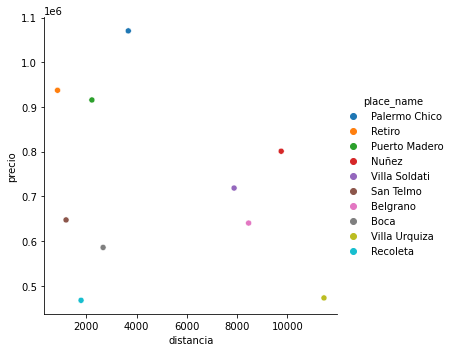

In [120]:
#Grafico relacion distancia precio top 10 precios
sns.relplot(x = 'distancia', y = 'precio', hue='place_name', data = data_rank_precio)

plt.show()

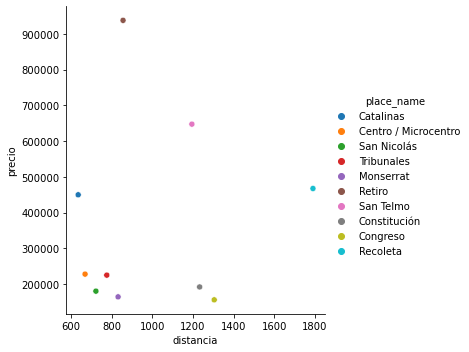

In [121]:
#Grafico relacion distancia precio top 10 distancia
sns.relplot(x = 'distancia', y = 'precio', hue='place_name', data = data_rank_distancia)

plt.show()

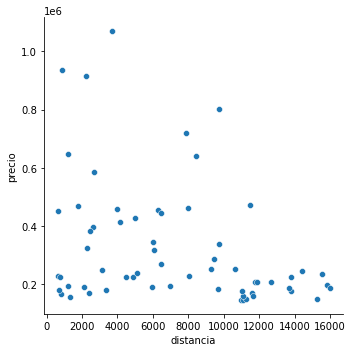

In [122]:
#Grafico relacion distancia precio todos.

sns.relplot(x = 'distancia', y = 'precio', data = geo_prop_group)

plt.show()